In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 128
latent_dim = 20
epochs = 20
learning_rate = 1e-3

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [ ]:

# Initialize the model and optimizer
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader.dataset):.4f}')

# Generate some samples
model.eval()
with torch.no_grad():
    sample = torch.randn(64, latent_dim)
    sample = model.decode(sample).cpu()

    fig, ax = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            ax[i,j].imshow(sample[i*8+j].reshape(28, 28), cmap='gray')
            ax[i,j].axis('off')

    plt.tight_layout()
    plt.show()

Epoch 1/30
VAE1 Loss: 289.8370
VAE2 Loss: 289.2350
Agreement: 0.7170
---
Epoch 2/30
VAE1 Loss: 254.0307
VAE2 Loss: 254.3211
Agreement: 0.7269
---
Epoch 3/30
VAE1 Loss: 248.1202
VAE2 Loss: 248.7819
Agreement: 0.7236
---
Epoch 4/30
VAE1 Loss: 245.6824
VAE2 Loss: 246.0759
Agreement: 0.7209
---
Epoch 5/30
VAE1 Loss: 244.0838
VAE2 Loss: 244.3652
Agreement: 0.7233
---
Epoch 6/30
VAE1 Loss: 242.9559
VAE2 Loss: 243.0186
Agreement: 0.7246
---
Epoch 7/30
VAE1 Loss: 242.0841
VAE2 Loss: 242.1857
Agreement: 0.7256
---
Epoch 8/30
VAE1 Loss: 241.4731
VAE2 Loss: 241.4950
Agreement: 0.7258
---
Epoch 9/30
VAE1 Loss: 240.9104
VAE2 Loss: 240.9060
Agreement: 0.7264
---
Epoch 10/30
VAE1 Loss: 240.4780
VAE2 Loss: 240.4353
Agreement: 0.7252
---
Epoch 11/30
VAE1 Loss: 240.0831
VAE2 Loss: 240.0358
Agreement: 0.7254
---
Epoch 12/30
VAE1 Loss: 239.7544
VAE2 Loss: 239.6843
Agreement: 0.7248
---
Epoch 13/30
VAE1 Loss: 239.4429
VAE2 Loss: 239.4389
Agreement: 0.7246
---
Epoch 14/30
VAE1 Loss: 239.2137
VAE2 Loss: 239.

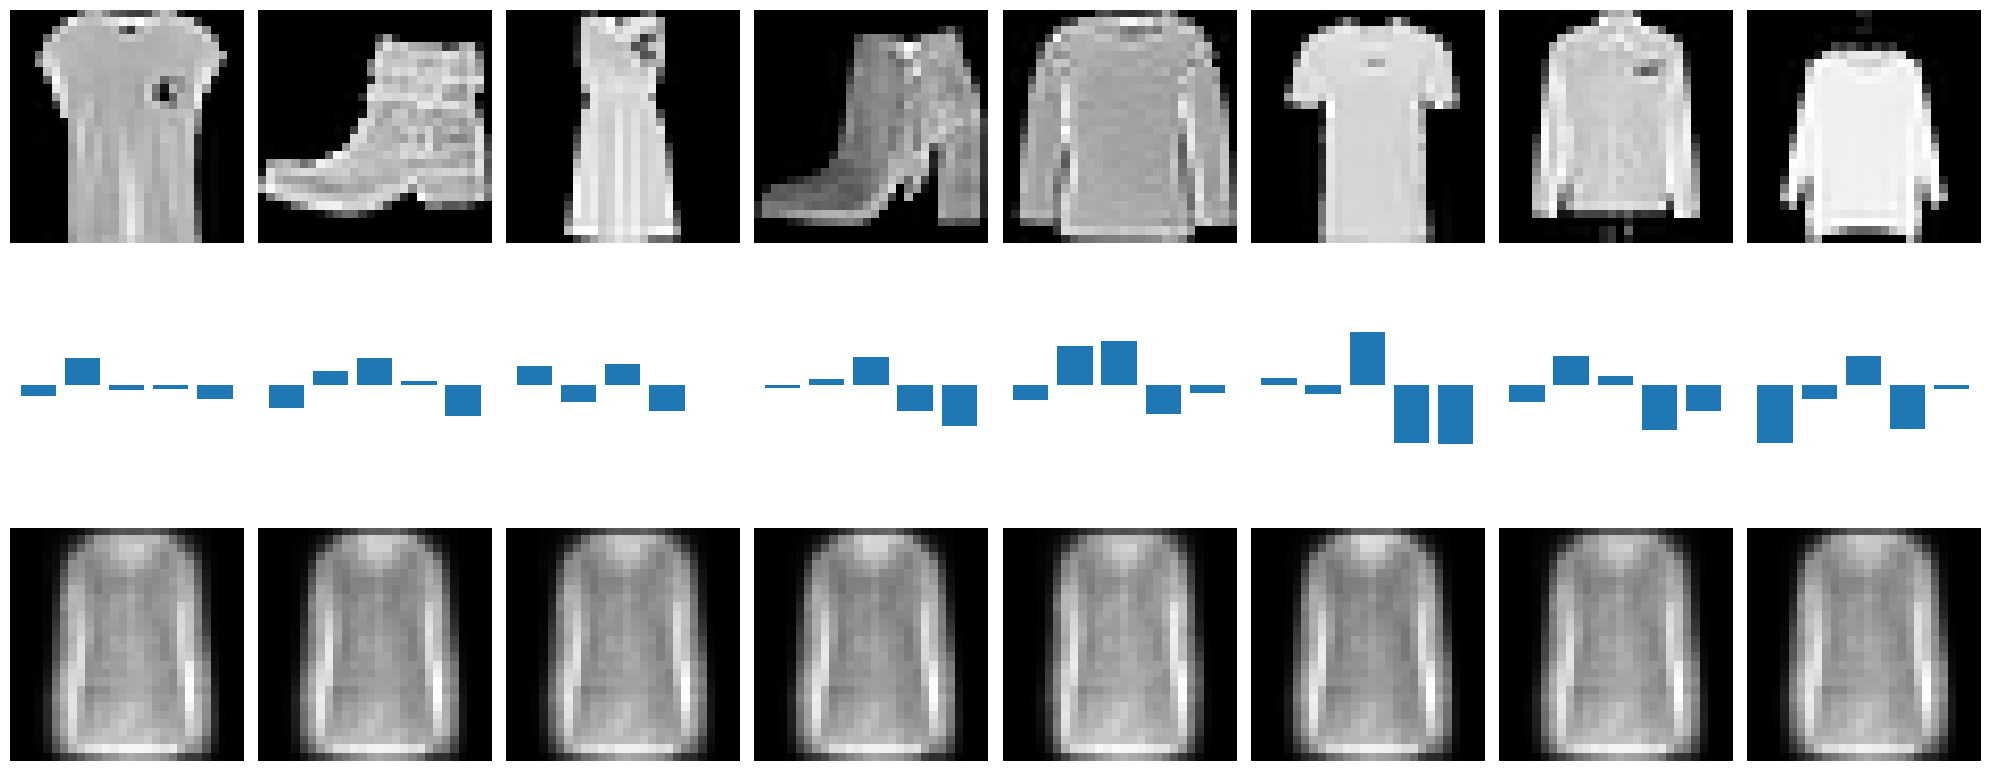

Final Agreement: 0.8072


In [ ]:
#Communicating VAEs
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Hyperparameters
batch_size = 128
latent_dim = 20
utterance_dim = 5  # New: dimension of the utterance
epochs = 30
learning_rate = 1e-3

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the VAE model with utterance generation and interpretation
class CommunicativeVAE(nn.Module):
    def __init__(self, latent_dim, utterance_dim):
        super(CommunicativeVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

        # Utterance generator
        self.utterance_generator = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, utterance_dim),
            nn.Tanh()  # Output between -1 and 1
        )

        # Utterance interpreter
        self.utterance_interpreter = nn.Sequential(
            nn.Linear(utterance_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def generate_utterance(self, z):
        return self.utterance_generator(z)

    def interpret_utterance(self, utterance):
        return self.utterance_interpreter(utterance)

# Initialize two VAE models
vae1 = CommunicativeVAE(latent_dim, utterance_dim)
vae2 = CommunicativeVAE(latent_dim, utterance_dim)

# Optimizers
optimizer1 = optim.Adam(vae1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(vae2.parameters(), lr=learning_rate)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Function to simulate communication between VAEs
def communicate(vae1, vae2, x):
    # VAE1 encodes and generates utterance
    _, mu1, logvar1 = vae1(x)
    z1 = vae1.reparameterize(mu1, logvar1)
    utterance = vae1.generate_utterance(z1)

    # VAE2 interprets utterance and reconstructs
    z2 = vae2.interpret_utterance(utterance)
    recon2 = vae2.decode(z2)

    # Calculate agreement as cosine similarity
    agreement = nn.functional.cosine_similarity(x.view(x.size(0), -1),
                                                recon2.view(recon2.size(0), -1)).mean()

    return agreement, utterance, recon2

# Training loop with communication
for epoch in range(epochs):
    vae1.train()
    vae2.train()
    train_loss1 = 0
    train_loss2 = 0
    total_agreement = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        # Train VAE1
        optimizer1.zero_grad()
        recon_batch1, mu1, logvar1 = vae1(data)
        loss1 = loss_function(recon_batch1, data, mu1, logvar1)
        loss1.backward()
        train_loss1 += loss1.item()
        optimizer1.step()

        # Train VAE2
        optimizer2.zero_grad()
        recon_batch2, mu2, logvar2 = vae2(data)
        loss2 = loss_function(recon_batch2, data, mu2, logvar2)
        loss2.backward()
        train_loss2 += loss2.item()
        optimizer2.step()

        # Simulate communication
        agreement, _, _ = communicate(vae1, vae2, data)
        total_agreement += agreement.item()

    avg_agreement = total_agreement / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}')
    print(f'VAE1 Loss: {train_loss1/len(train_loader.dataset):.4f}')
    print(f'VAE2 Loss: {train_loss2/len(train_loader.dataset):.4f}')
    print(f'Agreement: {avg_agreement:.4f}')
    print('---')

# Visualize results
vae1.eval()
vae2.eval()
with torch.no_grad():
    # Get a batch of test data
    test_loader = DataLoader(datasets.FashionMNIST(root='./data', train=False, transform=transform),
                             batch_size=8, shuffle=True)
    test_batch = next(iter(test_loader))[0]

    # Get reconstructions from both VAEs
    agreement, utterance, recon2 = communicate(vae1, vae2, test_batch)

    # Plot original images, utterances, and reconstructions
    fig, axes = plt.subplots(3, 8, figsize=(20, 8))
    for i in range(8):
        axes[0, i].imshow(test_batch[i].squeeze().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].bar(range(utterance_dim), utterance[i].numpy())
        axes[1, i].set_ylim(-1, 1)
        axes[1, i].axis('off')
        axes[2, i].imshow(recon2[i].view(28, 28).numpy(), cmap='gray')
        axes[2, i].axis('off')

    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Utterance')
    axes[2, 0].set_ylabel('VAE2 Recon')
    plt.tight_layout()
    plt.show()

print(f'Final Agreement: {agreement.item():.4f}')